## Implementing CPPI and Drawdown Constraints

In [87]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import edhec_risk_kit as erk
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
ind_return = erk.get_ind_returns()
tmi_return = erk.get_total_market_index_returns()

In [4]:
ind_return.head()

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


1. Cushion -- (Asset Value minus Floor Value)
2. Compute and Allocation to Safe and Risky Assets --> `m*risk_budget`
3. Recompute the Asset Value based on the returns

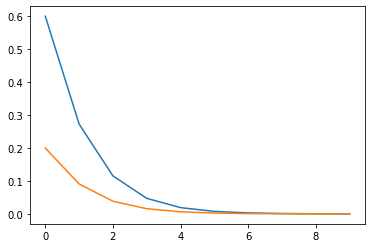

In [89]:
def cppi(risky_r, safe_r, floor = .8, m = 3, n = 10):
    account_value = np.zeros(n)
    cushion_history = np.zeros(n)
    risky_w_history = np.zeros(n)
    account_value[0] = 1
    for i in range(1,n):
        
        cushion = (account_value[i-1] - floor)/account_value[i-1]
        cushion_history[i-1] = cushion
        risky_w = m * cushion
        risky_w_history[i-1] = risky_w
        # make sure risk proportion is within 0-1 bounds
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1 - risky_w
        risky_alloc = account_value[i-1] * risky_w
        safe_alloc = account_value[i-1] * safe_w

        account_value[i] = risky_alloc*risky_r[i] + safe_alloc*safe_r[i]
    return account_value, cushion_history, risky_w_history

n = 10
risky_r = np.ones(n) * .8
safe_r = np.ones(n)
y, c, rw = cppi(risky_r, safe_r, n=n)
plt.plot(rw)
plt.plot(c)
plt.show()

In [90]:
risky_r = ind_return["2000":][["Steel", "Fin", "Beer"]]
# Assume the safe asset is paying 3% per year
safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.values[:] = 0.03/12 # fast way to set all values to a number
start = 1000 # start at $1000
floor = 0.80 # set the floor to 80 percent of the starting value

# set up the CPPI parameters
dates = risky_r.index
n_steps = len(dates)
account_value = start
peak = start
floor_value = start*floor
m = 3
## set up some DataFrames for saving intermediate values
account_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)
for step in range(n_steps):
    peak = np.maximum(account_value, peak)
    floor_value = peak * floor
    
    cushion = (account_value - floor_value)/account_value
    risky_w = m*cushion
    risky_w = np.minimum(risky_w, 1)
    risky_w = np.maximum(risky_w, 0)
    safe_w = 1-risky_w
    risky_alloc = account_value*risky_w
    safe_alloc = account_value*safe_w
    # recompute the new account value at the end of this step
    account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
    # save the histories for analysis and plotting
    cushion_history.iloc[step] = cushion
    risky_w_history.iloc[step] = risky_w
    account_history.iloc[step] = account_value
    floor_history.iloc[step] = floor_value

<AxesSubplot:>

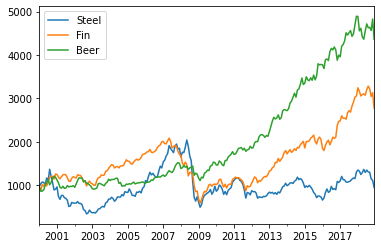

In [91]:
risky_wealth = start*(1+risky_r).cumprod()
risky_wealth.plot()

<AxesSubplot:>

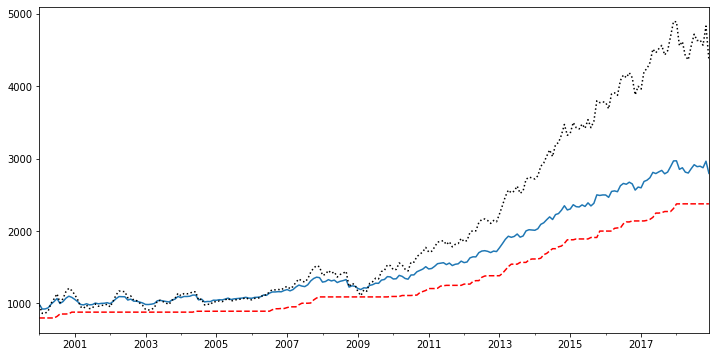

In [93]:
ax = account_history["Beer"].plot(figsize=(12,6))
risky_wealth["Beer"].plot(ax=ax, style="k:")
floor_history["Beer"].plot(ax=ax, style='r--')

<AxesSubplot:>

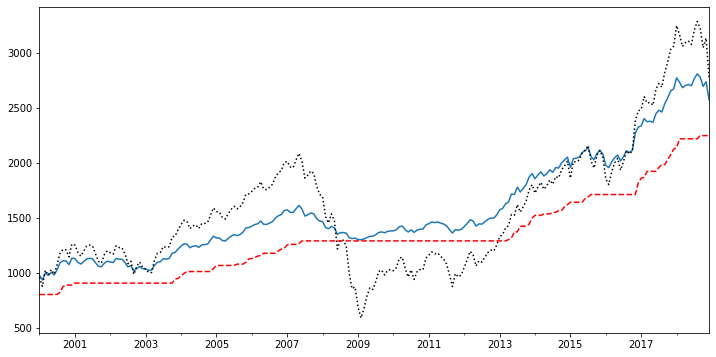

In [94]:
ax = account_history["Fin"].plot(figsize=(12,6))
risky_wealth["Fin"].plot(ax=ax, style="k:")
floor_history["Fin"].plot(ax=ax, style='r--')

<AxesSubplot:>

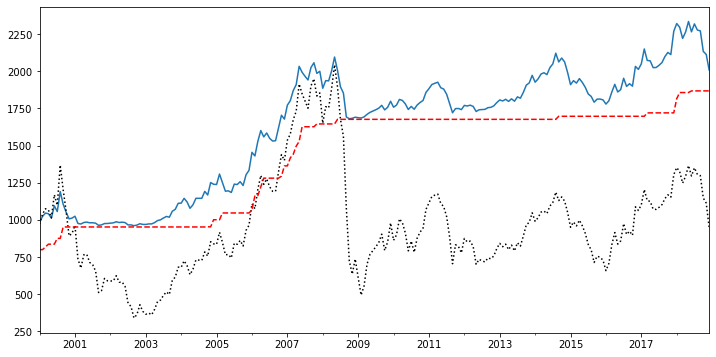

In [95]:
ax = account_history["Steel"].plot(figsize=(12,6))
risky_wealth["Steel"].plot(ax=ax, style="k:")
floor_history["Steel"].plot(ax=ax, style='r--')

## Extensions

* Gap risk? Solution hint: Multiplier callibration.
* Dynamic floor, Cap:

$$
E_t = m(A_t - F_t), F_t \le A_t \le T_t \\
E_t = m(C_t - A_t), T_t \le A_t \le C_t \\
T_t= \frac{F_t + C_t}{2}
$$